# Face cell simulations with linear decoder

This notebook contains code that will synthesize a population of neurons responding to features defined by the eigendecomposition of a large face image set. These synthesized repsonses are then used as ground truth to simulate several presentations of these images using the temporal multiplexing model proposed in Caruso et al. (2018). Several parameters can be tuned to determine their impact on the ability to decode face identity from the population. This is the second approach used in my course project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 1: Generate eigenface space 

The face features that neurons are tuned to are defined by the eigendecomposition of a large face image set. I use the first 100 PCs following on the finding in Chang & Tsao that a 100-dimensional face space does a good job characterizing cells in the macaque face patch system.

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=20) # want to maximize number of faces
print(faces.images.shape)

(3023, 62, 47)


(100,)


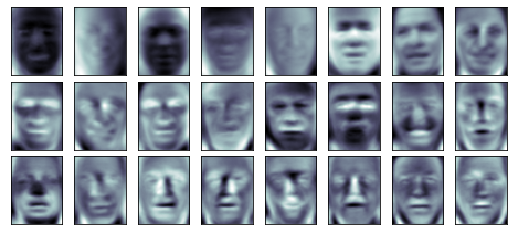

In [3]:
pca = PCA(100, svd_solver='randomized') # bring to 100 components 
pca.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
    
components = pca.transform(faces.data)
print(components[0].shape)

# Step 2: Generate neural population weights

For each unit I randomly assign a single feature for which it is strongly tuned and assign the rest of the features random weights that sum the total weights to 1. The non-linearity is to set all values below 0 to 0. I also apply an arbitrary linear transformation on the output to get distributions that look more like SC distributions. Several of these decisions are arbitrary and could be tweaked in future iterations.

I tried rotating in feature space and in neural space. Because of the chosen non-linearities I found that rotations in feature space overestimated rotations in neural space. Future work could explore these decisions and try to find a better mapping, but for the project I abandoned the feature space rotations and just focused on rotations in neural space.

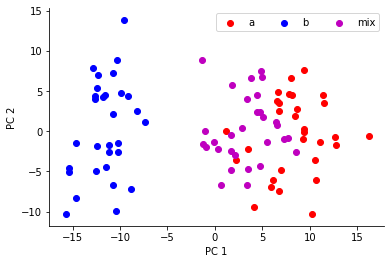

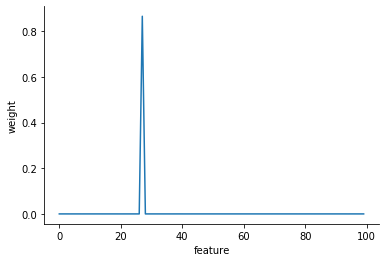

In [5]:
def gen_weights(num_neurons, num_features): 
    # Simulate random feature weights for each neuron
    W = np.empty((num_neurons, num_features))
    for i in range(num_neurons):
        principle_feature = np.random.randint(0, num_features) # choose principle feature to encode
        W[i, principle_feature] = np.random.normal(0, 0.05) + 0.85 # tuning of principle feature

        # Algorithm to fill remaining weights with what's needed to get to sum of 1
        sum_left = 1 - W[i, principle_feature]
        all_features = np.ones(num_features)
        all_features[principle_feature] = 0
        all_features = np.multiply(all_features, np.arange(num_features)+1)-1 # sets to -1 when not included
        rand_vec = np.random.normal(15, 0.1, (num_features-1,1)) # Generate random vector
        rand_vec = rand_vec / np.linalg.norm(rand_vec, ord=1) # normalize to length 1
        weights = np.multiply(rand_vec, sum_left) # scale to desired length

        weight_cnt = 0;
        for j in range(len(all_features)):
            if all_features[j] != -1:
                W[i, j] = weights[weight_cnt]
                weight_cnt += 1
                
    return W


def rectifying_nonlinearity(resp):
    for i in range(0, len(resp)):
        if resp[i] < 0:
            resp[i] = 0
    return resp


def simulate_response(W, features):
    features = features / np.linalg.norm(features, ord=2)
    resp = features @ W.T # Predict the response to this image
    resp = (resp * 40) + 5
    resp = rectifying_nonlinearity(resp.ravel())
    
    return resp


def gen_rotated_feat(a, theta, num_neurons, num_features):

    a = a / np.linalg.norm(a, ord=2) # normalize feature vector to unit length
    
    # Rotate vector a by specified number of degrees to generate vector b
    rand_vec = np.random.randn(num_features,) # random vector we can orthogonalize wrt original
    orth_vec = rand_vec - (((rand_vec.T@a)/(a.T@a))*a) # orthogonalize wrt input

    # normalize to unit length
    norm = a * (1/ np.linalg.norm(a))
    orth_vec_norm = orth_vec * (1/ np.linalg.norm(orth_vec))

    # Generate new vector at given angle
    b = (norm * np.cos(np.radians(theta))) + (orth_vec_norm*np.sin(np.radians(theta))) # generate second vector
    b = b * np.linalg.norm(a) # scale new vector up to same size as original
        
    return b


def gen_rotated_neural(a, theta, num_neurons, num_features):
    # Rotate vector a by specified number of degrees to generate vector b
    rand_vec = np.random.randn(num_neurons,) # random vector we can orthogonalize wrt original
    orth_vec = rand_vec - (((rand_vec.T@a)/(a.T@a))*a) # orthogonalize wrt a

    # normalize to unit length
    a_norm = a * (1/ np.linalg.norm(a))
    orth_vec_norm = orth_vec * (1/ np.linalg.norm(orth_vec))

    b = (a_norm * np.cos(np.radians(theta))) + (orth_vec_norm*np.sin(np.radians(theta))) # generate second vector
    b = b * np.linalg.norm(a) # scale new vector up to same size as original
    
    return b


def poisson_draws(a, b, num_pres, prop_maj, num_neurons):
    # Simulate response of num_pres presentations of each image and images together
    a_draws = np.empty((num_neurons, num_pres))
    b_draws = np.empty((num_neurons, num_pres))
    mix_draws = np.empty((num_neurons, num_pres))
    for i in range(0, num_neurons):
        if a[i] <= 0 and b[i] > 0:
            a_draws[i, :] = np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres)) * -1
            b_draws[i, :] = np.random.poisson(lam=b[i], size=(1, num_pres))
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres))) * -1 + ((1-prop_maj) * np.random.poisson(lam=b[i], size=(1, num_pres))) # mixture model from Car
        elif a[i] <= 0 and b[i] <= 0: 
            a_draws[i, :] = np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres)) * -1
            b_draws[i, :] = np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=np.abs(a[i]), size=(1, num_pres))) * -1 + ((1-prop_maj) * np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1) # mixture model from Car
        elif a[i] > 0 and b[i] <= 0:
            a_draws[i, :] = np.random.poisson(lam=a[i], size=(1, num_pres))
            b_draws[i, :] = np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=a[i], size=(1, num_pres))) + ((1-prop_maj) * np.random.poisson(lam=np.abs(b[i]), size=(1, num_pres)) * -1) # mixture model from Car
        elif a[i] > 0 and b[i] > 0:
            a_draws[i, :] = np.random.poisson(lam=a[i], size=(1, num_pres))
            b_draws[i, :] = np.random.poisson(lam=b[i], size=(1, num_pres))
            mix_draws[i, :] = (prop_maj * np.random.poisson(lam=a[i], size=(1, num_pres))) + ((1-prop_maj) * np.random.poisson(lam=b[i], size=(1, num_pres))) # mixture model from Car
 
    return a_draws, b_draws, mix_draws


num_neurons = 50
num_features = 100 # based on 100-dimensional face space in Chang & Tsao
theta = 20
num_pres = 30
prop_maj = 0.75
W = gen_weights(num_neurons, num_features)
resp = simulate_response(W, components[17])
resp_rot = gen_rotated_neural(resp, theta, num_neurons, num_features)
# resp_rot = simulate_response(W, feat_rot)
a_draws, b_draws, mix_draws = poisson_draws(resp, resp_rot, num_pres, prop_maj, num_neurons)

# Fit PCA model from sklearn
labels = np.concatenate((np.zeros((1, num_pres)), np.zeros((1, num_pres))+1, np.zeros((1, num_pres))+2), axis=1)
all_resp = np.concatenate((a_draws, b_draws, mix_draws), axis=1)
pca = PCA(n_components=2)
pca.fit(all_resp.T)
pc_activations = pca.transform(all_resp.T)

# Plot for visualization
fig, ax = plt.subplots()
c_resp = ['r', 'b', 'm']
f_labels = ['a', 'b', 'mix']

for i in range(0, 3):
    ax.scatter(pc_activations[(labels==i).reshape(num_pres*3,), 0], pc_activations[(labels==i).reshape(num_pres*3,), 1], c=c_resp[i], label=f_labels[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=3)
plt.show()

fig, ax = plt.subplots()

plt.plot(W[4,:])
ax.set_ylabel('weight')
ax.set_xlabel('feature')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Step 3: Train linear decoders

This step follows the same procedure used in approach 1. On each iteration I start with a given feature vector to generate a neural response and then find a second neural response that is at a given angle from the original. 

There are occassional errors with fitting the linear decoder, but the code runs and ignores these few iterations of cross-validation.

In [8]:
def cross_validated_decoder_feat_rot(num_pres, num_units, num_features, prop_maj, theta):
    num_itr = 1000 # number of iterations of cross-validation

    # Loop through iterations of cross-validation
    mean_perf_a = np.zeros(num_itr,)
    mean_perf_b = np.zeros(num_itr,)
    prop_b = np.zeros(num_itr,)
    for i in range(0, num_itr):
        if i % 50 == 0:
            print('#', end = '')

        W = gen_weights(num_units, num_features)
        resp = simulate_response(W, components[17])
        resp_rot = gen_rotated_feat(components[17], theta, num_units, num_features)
        resp_rot = simulate_response(W, resp_rot)
        a_draws, b_draws, mix_draws = poisson_draws(resp, resp_rot, num_pres, prop_maj, num_units)
        
        resp_single = np.concatenate((a_draws, b_draws), axis=1)
        label_single = np.concatenate((np.zeros((1, num_pres)), np.zeros((1, num_pres))+1), axis=1).reshape(num_pres*2,)
        X_train, X_test, y_train, y_test = train_test_split(resp_single.T, label_single.T, test_size=0.2)
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred_acc = 1 - np.abs(y_test - pred)
        mean_perf_a[i] = np.mean(pred_acc[y_test==1])
        mean_perf_b[i] = np.mean(pred_acc[y_test==0])

        # run multiplexed signal through model
        pred_mp = model.predict(mix_draws.T)
        prop_b[i] = np.mean(pred_mp)
        
    print('')

    return mean_perf_a, mean_perf_b, prop_b

def cross_validated_decoder_neural_rot(num_pres, num_units, num_features, prop_maj, theta):
    num_itr = 1000 # number of iterations of cross-validation

    # Loop through iterations of cross-validation
    mean_perf_a = np.zeros(num_itr,)
    mean_perf_b = np.zeros(num_itr,)
    prop_b = np.zeros(num_itr,)
    for i in range(0, num_itr):
        if i % 50 == 0:
            print('#', end = '')

        W = gen_weights(num_units, num_features)
        resp = simulate_response(W, components[17])
        resp_rot = gen_rotated_neural(resp, theta, num_units, num_features)
        a_draws, b_draws, mix_draws = poisson_draws(resp, resp_rot, num_pres, prop_maj, num_units)
        
        resp_single = np.concatenate((a_draws, b_draws), axis=1)
        label_single = np.concatenate((np.zeros((1, num_pres)), np.zeros((1, num_pres))+1), axis=1).reshape(num_pres*2,)
        X_train, X_test, y_train, y_test = train_test_split(resp_single.T, label_single.T, test_size=0.2)
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred_acc = 1 - np.abs(y_test - pred)
        mean_perf_a[i] = np.mean(pred_acc[y_test==1])
        mean_perf_b[i] = np.mean(pred_acc[y_test==0])

        # run multiplexed signal through model
        pred_mp = model.predict(mix_draws.T)
        prop_b[i] = np.mean(pred_mp)
        
    print('')

    return mean_perf_a, mean_perf_b, prop_b

num_neurons = 50
num_features = 100 # based on 100-dimensional face space in Chang & Tsao
prop_maj = 0.75
theta = 10
num_pres = 75
mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder_feat_rot(num_pres, num_neurons, num_features, prop_maj, theta)

print(np.mean(mean_perf_a))
print(np.mean(mean_perf_b))
print(np.mean(prop_b))


####################
0.7188874896227821
0.727158082628511
0.35090666666666664


In [7]:
default_num_pres = 30 # number of presentations to simulate
default_num_units = 50 # number of units in the population (max 534 recorded)
default_prop_maj = 0.75 # likelihood of representing stimulus a vs. stimulus b (<0.5 favors b, >0.5 favors a)
default_theta = 20 # angle between vectors a and b (deg)

## a. Change number of units

This simulation has the same problem as approach 1 where there's a weird dip in performance around ~75 units. This remains unresolved.

In [15]:
num_units_range = [10, 30, 50, 75, 90, 150, 200, 300]
perf_by_units_a = np.empty((len(num_units_range),))
perf_by_units_b = np.empty((len(num_units_range),))
prop_b_by_units = np.empty((len(num_units_range),))
for i in range(0, len(num_units_range)):
    mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder_neural_rot(default_num_pres, num_units_range[i], num_features, default_prop_maj, default_theta)
    perf_by_units_a[i] = np.nanmean(mean_perf_a)
    perf_by_units_b[i] = np.nanmean(mean_perf_b)
    prop_b_by_units[i] = np.nanmean(prop_b)


####################
####################
####################
####################
####################
####################
####################
####################


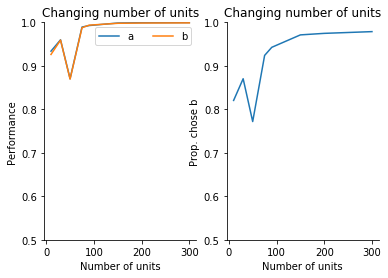

In [16]:
# Plot for visualization
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(num_units_range, perf_by_units_a, label='a')
ax1.plot(num_units_range, perf_by_units_b, label='b')

ax1.set_ylabel('Performance')
ax1.set_xlabel('Number of units')
ax1.set_title('Changing number of units')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend()
ax1.legend(ncol=2)
ax1.set(ylim=(0.5, 1))

ax2.plot(num_units_range, 1-prop_b_by_units)

ax2.set_ylabel('Prop. chose b')
ax2.set_xlabel('Number of units')
ax2.set_title('Changing number of units')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set(ylim=(0.5, 1))

plt.show()


## b. Change angle between vectors

In [11]:
theta_range = [0, 3, 5, 7, 10, 15, 20, 30, 40, 50, 60]
perf_by_units_a = np.empty((len(theta_range),))
perf_by_units_b = np.empty((len(theta_range),))
prop_b_by_units = np.empty((len(theta_range),))
for i in range(0, len(theta_range)):
    mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder_neural_rot(default_num_pres, default_num_units, num_features, default_prop_maj, theta_range[i])
    perf_by_units_a[i] = np.nanmean(mean_perf_a)
    perf_by_units_b[i] = np.nanmean(mean_perf_b)
    prop_b_by_units[i] = np.nanmean(prop_b)


####################
####################
####################
####################
############

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


########
####################
####################
####################
####################
####################
####################


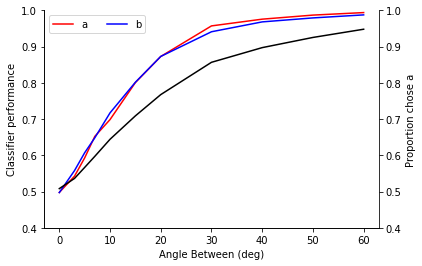

In [12]:
# Plot for visualization
fig, ax1 = plt.subplots()

ax1.plot(theta_range, perf_by_units_a, 'r-', label='a')
ax1.plot(theta_range, perf_by_units_b, 'b-', label='b')

ax1.set_ylabel('Classifier performance')
ax1.set_xlabel('Angle Between (deg)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend()
ax1.legend(ncol=2)
ax1.set(ylim=((0.4, 1)))

ax2 = ax1.twinx()
ax1.plot(theta_range, 1-prop_b_by_units, 'k-')

ax2.set_ylabel('Proportion chose a')
ax2.set_xlabel('Angle Between (deg)')
ax2.spines['top'].set_visible(False)
ax2.set(ylim=((0.4, 1)))

plt.show()

## c. Change bias in the population

In [17]:
propmaj_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
perf_by_units_a = np.empty((len(propmaj_range),))
perf_by_units_b = np.empty((len(propmaj_range),))
prop_b_by_units = np.empty((len(propmaj_range),))
for i in range(0, len(propmaj_range)):
    mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder_neural_rot(default_num_pres, default_num_units, num_features, propmaj_range[i], default_theta)
    perf_by_units_a[i] = np.nanmean(mean_perf_a)
    perf_by_units_b[i] = np.nanmean(mean_perf_b)
    prop_b_by_units[i] = np.nanmean(prop_b)


####################
####################
####################
####################
####################
####################
####################
####################
####

/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cmhacker/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


################
####################
####################


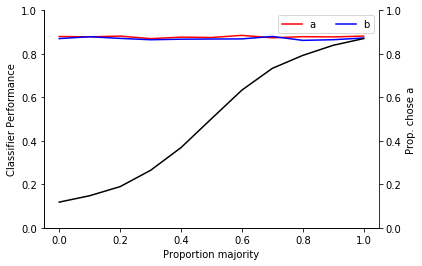

In [18]:
# Plot for visualization
fig, ax1 = plt.subplots()

ax1.plot(propmaj_range, perf_by_units_a, 'r-', label='a')
ax1.plot(propmaj_range, perf_by_units_b, 'b-', label='b')

ax1.set_ylabel('Classifier Performance')
ax1.set_xlabel('Proportion majority')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend()
ax1.legend(ncol=2)
ax1.set(ylim=((0, 1)))

ax2 = ax1.twinx()
ax2.plot(propmaj_range, 1-prop_b_by_units, 'k-')

ax2.set_ylabel('Prop. chose a')
ax2.set_xlabel('Proportion majority')
ax2.spines['top'].set_visible(False)
ax2.set(ylim=((0, 1)))

plt.show()

## d. Change angle between and bias

In [19]:
theta_test = [0, 10, 20, 30, 40, 50]
propMaj_test = [0, 0.2, 0.4, 0.6, 0.8, 1]
perf_by_units_a = np.empty((len(propMaj_test),len(theta_test)))
perf_by_units_b = np.empty((len(propMaj_test),len(theta_test)))
prop_b_by_units = np.empty((len(propMaj_test),len(theta_test)))
for i in range(0, len(propMaj_test)):
    for j in range(0, len(theta_test)):
        mean_perf_a, mean_perf_b, prop_b = cross_validated_decoder_neural_rot(default_num_pres, default_num_units, num_features, propMaj_test[i], theta_test[j])
        perf_by_units_a[i, j] = np.nanmean(mean_perf_a)
        perf_by_units_b[i, j] = np.nanmean(mean_perf_b)
        prop_b_by_units[i, j] = np.nanmean(prop_b)


####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################
####################


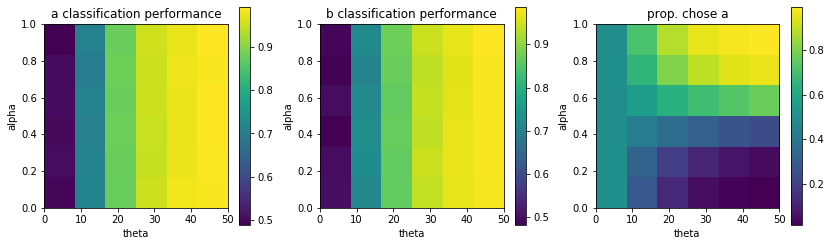

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

a = ax1.imshow(perf_by_units_a, extent=[0, 1, 0, 1])
ax1.set_ylabel('alpha')
ax1.set_xlabel('theta')
ax1.set_title('a classification performance')
ax1.set(ylim=((0, 1)))
t = plt.colorbar(a, ax=ax1)
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels(['0', '10', '20', '30', '40', '50'])

b = ax2.imshow(perf_by_units_b, extent = [0, 1, 0, 1])
ax2.set_ylabel('alpha')
ax2.set_xlabel('theta')
ax2.set_title('b classification performance')
t = plt.colorbar(b, ax=ax2)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_xticklabels(['0', '10', '20', '30', '40', '50'])

c = ax3.imshow(prop_b_by_units, extent = [0, 1, 0, 1])
ax3.set_ylabel('alpha')
ax3.set_xlabel('theta')
ax3.set_title('prop. chose a')
t = plt.colorbar(c, ax=ax3)
ax3.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
t = ax3.set_xticklabels(['0', '10', '20', '30', '40', '50'])
